# Урок 2. Масштабирование признаков. L1- и L2-регуляризация. Стохастический градиентный спуск

1. Постройте график зависимости весов всех признаков от $\lambda$ в самописной L2-регуляризации (на данных про ЕГЭ). Сделайте вывод.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
X = np.array([[   1,    1,  500,    1],
              [   1,    1,  700,    1],
              [   1,    2,  750,    2],
              [   1,    5,  600,    1],
              [   1,    3, 1450,    2],
              [   1,    0,  800,    1],
              [   1,    5, 1500,    3],
              [   1,   10, 2000,    3],
              [   1,    1,  450,    1],
              [   1,    2, 1000,    2]])
y = [45, 55, 50, 55, 60, 35, 75, 80, 50, 60]

In [3]:
def standard_scale(X):
    mean = X.mean()
    std = X.std()
    return (X - mean) / std
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [4]:
X_st = X.copy().astype(np.float64)
X_st[:, 1] = standard_scale(X_st[:, 1])
X_st[:, 2] = standard_scale(X_st[:, 2])
X_st[:, 3] = standard_scale(X_st[:, 3])

X_st

array([[ 1.        , -0.70710678, -0.97958969, -0.89625816],
       [ 1.        , -0.70710678, -0.56713087, -0.89625816],
       [ 1.        , -0.35355339, -0.46401617,  0.38411064],
       [ 1.        ,  0.70710678, -0.77336028, -0.89625816],
       [ 1.        ,  0.        ,  0.97958969,  0.38411064],
       [ 1.        , -1.06066017, -0.36090146, -0.89625816],
       [ 1.        ,  0.70710678,  1.08270439,  1.66447944],
       [ 1.        ,  2.47487373,  2.11385144,  1.66447944],
       [ 1.        , -0.70710678, -1.08270439, -0.89625816],
       [ 1.        , -0.35355339,  0.05155735,  0.38411064]])

Модифицируем функцию для градиентного спуска с L2-регуляризацией, представленную на занятии, чтобы выход осуществлялся не только по количеству итераций, но и по критерию сходимости весов.

In [5]:
def gradient_descent_reg_l2(X, y, iterations, eta=1e-4, reg=1e-8):
    # Зададим случайные начальные значения
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    
    # критерий сходимости (разница весов, при которой алгоритм останавливается)
    min_weight_dist = 1e-8
    
    # зададим начальную разницу весов большим числом
    weight_dist = np.inf
    
    # счетчик итераций
    iter_num = 0
    
    
    while weight_dist > min_weight_dist and iter_num < iterations:
        y_pred = np.dot(X, W)
        err = calc_mse(y, y_pred)
        
        dQ = 2/n * X.T @ (y_pred - y) # градиент функции ошибки
        dReg = reg * W # градиент регуляризации
        
        new_W = W - eta * (dQ + dReg)
        
        weight_dist = np.linalg.norm(new_W - W, ord=2)
        
        iter_num += 1
        W = new_W
    
#     print(f'Final MSE: {calc_mse(y, np.dot(X, W))}')
    return W

In [6]:
gradient_descent_reg_l2(X_st, y, iterations=5000, eta=1e-2, reg=1e-4)

array([56.49717514,  6.30231315, -0.35421985,  6.56976687])

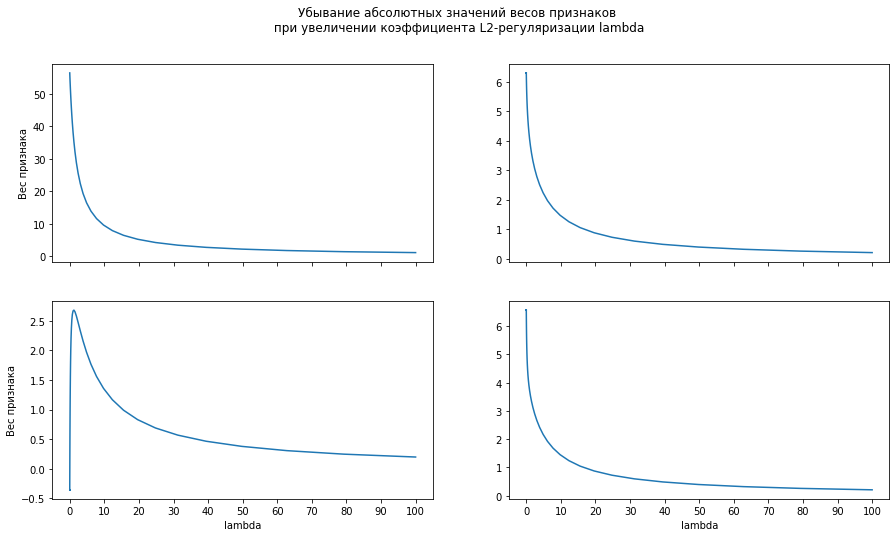

In [7]:
n = 100

coeffs = np.zeros((n, X_st.shape[1]))
lambda_list = np.logspace(-8, 2, n)

for i, val in enumerate(lambda_list):
    coeffs[i, :] = gradient_descent_reg_l2(X_st, y, iterations=5000, eta=1e-2, reg=val)
    
    
fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharex=True)
ax1, ax2, ax3, ax4 = axs.flatten()


for i, ax in enumerate(axs.flatten()):
    ax.plot(lambda_list, coeffs[:, i])

fig.suptitle('Убывание абсолютных значений весов признаков\n при увеличении коэффициента L2-регуляризации lambda')
ax1.set_xticks(np.arange(0, 101, 10))
ax3.set_xlabel('lambda')
ax4.set_xlabel('lambda')
ax1.set_ylabel('Вес признака')
ax3.set_ylabel('Вес признака')

plt.show()

Как видно из построенных графиков при небольших $\lambda$ значения весов признаков большие, что может косвенно указывать на переобучение и одновременно свидетельствует о том, что регуляризация не оказывает большого влияния на модель. При росте коэффициента регуляризации $\lambda$ значения весов начинают убывать, так как в силу построения он штрафует за большие величины.

2. Напишите функцию наподобие gradient_descent_reg_l2, но для применения L1-регуляризации.

В случае L1-регуляризации мы имеем дело со следующей задачей:
#### $$Q(w, X) + \lambda |w| \rightarrow \underset{w}{\text{min}}.$$

In [8]:
def gradient_descent_reg_l1(X, y, iterations, eta=1e-4, reg=1e-8):
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    
    for i in range(0, iterations):
        y_pred = np.dot(X, W)
        err = calc_mse(y, y_pred)
        
        dQ = 2/n * X.T @ (y_pred - y) # градиент функции ошибки
#         dReg = reg * W / abs(W) # градиент регуляризации
        dReg = reg * np.sign(W)
        
        W -= eta * (dQ + dReg)
        
        if i % (iterations / 10) == 0:
            print(f'Iter: {i}, weights: {W}, error {err}')
    
    print(f'Final MSE: {calc_mse(y, np.dot(X, W))}')
    return W

In [9]:
gradient_descent_reg_l1(X_st, y, iterations=10000, eta=1e-2, reg=1e-4)

Iter: 0, weights: [1.41415673 0.75120635 0.29502026 0.39504455], error 3302.307937575726
Iter: 1000, weights: [56.49994991  6.19243463  0.16305401  6.14559188], error 24.952122728200827
Iter: 2000, weights: [56.49995     6.28899257 -0.28873117  6.51569663], error 24.905427312546585
Iter: 3000, weights: [56.49995     6.30109155 -0.34710532  6.56387122], error 24.90463404996145
Iter: 4000, weights: [56.49995     6.30265806 -0.35466784  6.57011326], error 24.90461939415558
Iter: 5000, weights: [56.49995     6.30286101 -0.35564762  6.57092196], error 24.904618974456046
Iter: 6000, weights: [56.49995     6.30288731 -0.35577456  6.57102674], error 24.904618944907337
Iter: 7000, weights: [56.49995     6.30289071 -0.35579101  6.57104031], error 24.904618941495784
Iter: 8000, weights: [56.49995     6.30289116 -0.35579314  6.57104207], error 24.90461894106079
Iter: 9000, weights: [56.49995     6.30289121 -0.35579342  6.5710423 ], error 24.90461894100454
Final MSE: 24.904618940997256


array([56.49995   ,  6.30289122, -0.35579345,  6.57104233])

3. *Можно ли к одному и тому же признаку применить сразу и нормализацию, и стандартизацию?

Нормализация и стандартизация являются методами масштабирования признаков. Значит достаточно применения одного из указанных методов, т.к. если мы применим сначала нормализацию, а потом стандартизацию, то это будет равносильно применению стандартизации к изначальному признаку. Аналогично, если мы применим сначала стандартизацию, а потом нормализацию, то это будет равносильно применению нормализации к исходному признаку.

In [10]:
X = np.array([[   1,    1,  500,    1],
              [   1,    1,  700,    1],
              [   1,    2,  750,    2],
              [   1,    5,  600,    1],
              [   1,    3, 1450,    2],
              [   1,    0,  800,    1],
              [   1,    5, 1500,    3],
              [   1,   10, 2000,    3],
              [   1,    1,  450,    1],
              [   1,    2, 1000,    2]])

In [11]:
def min_max_scale(X):
    return (X - X.min()) / (X.max() - X.min())
def standard_scale(X):
    mean = X.mean()
    std = X.std()
    return (X - mean) / std

Применим сначала нормализацию, а затем стандартизацию ко второму признаку, и сравним полученный результат с примененим стандартизации к исходному признаку.

In [12]:
standard_scale(min_max_scale(X[:, 2]))

array([-0.97958969, -0.56713087, -0.46401617, -0.77336028,  0.97958969,
       -0.36090146,  1.08270439,  2.11385144, -1.08270439,  0.05155735])

In [13]:
standard_scale(X[:, 2])

array([-0.97958969, -0.56713087, -0.46401617, -0.77336028,  0.97958969,
       -0.36090146,  1.08270439,  2.11385144, -1.08270439,  0.05155735])

Теперь наоборот применим сначала стандартизацию, а затем нормализацию ко второму признаку, и сравним полученный результат с примененим нормализации к исходному признаку.

In [14]:
min_max_scale(standard_scale(X[:, 2]))

array([0.03225806, 0.16129032, 0.19354839, 0.09677419, 0.64516129,
       0.22580645, 0.67741935, 1.        , 0.        , 0.35483871])

In [15]:
min_max_scale(X[:, 2])

array([0.03225806, 0.16129032, 0.19354839, 0.09677419, 0.64516129,
       0.22580645, 0.67741935, 1.        , 0.        , 0.35483871])

4. *Сгенерируйте датасет при помощи <code>sklearn.datasets.make_regression</code> и обучите линейную модель при помощи градиентного и стохастического градиентного спуска. Нанесите среднеквадратичную ошибку для обоих методов на один график, сделайте выводы о разнице скорости сходимости каждого из методов.

In [16]:
X, Y, coef = datasets.make_regression(n_samples=1000, n_features=5, n_informative=4, n_targets=1, 
                                      noise=5, coef=True, random_state=2)
X[:, 0] *= 10
X[:, 2] *= 100
display(X, Y, coef)

array([[ 1.04547799e+01, -3.59474459e-01, -3.51262461e+01,
         1.36901602e+00,  7.25353259e-01],
       [-1.11166511e+01,  4.24282093e-01, -8.74861988e-01,
         6.41257707e-01,  1.37630666e+00],
       [ 6.35363758e+00,  5.35558351e-01,  4.25606211e+01,
         2.10222927e+00,  6.61264168e-02],
       ...,
       [-1.59513440e+01,  1.74122456e+00, -4.43511462e+01,
        -3.97705756e-01,  6.28684111e-04],
       [-1.50147041e+00, -1.96641082e-01, -7.92235557e+01,
         8.58841063e-01,  2.04263282e-01],
       [-1.14290703e+01, -1.17213903e+00, -1.21518044e+02,
         1.83882497e-01, -8.69633650e-02]])

array([ 1.88480936e+02,  2.75264458e+01,  2.52305757e+02,  1.87185648e+01,
        7.64697989e+01,  1.07803610e+02,  1.70040277e+02, -8.86452495e+01,
        1.45075657e+02, -4.93970213e+01,  9.71057701e+01, -6.73976892e+01,
       -6.11603687e+01,  1.55818719e+02, -9.31925859e+01, -1.12986179e+02,
        3.11198843e+01,  9.96500709e+01, -1.90059363e+02,  7.00194325e+01,
        6.19585015e+01,  6.86129004e+01, -1.32216557e+01, -1.91423316e+02,
       -2.46373391e+02, -1.39139932e+01, -1.90087165e+02, -1.20102876e+02,
       -1.42474449e+00,  4.02892593e+01,  3.63123429e+01,  1.49695048e+01,
        2.96191394e+01,  1.85925902e+01,  1.02681254e+02, -8.30053196e+01,
       -2.10665040e+02, -1.33525873e+02,  1.21668567e+02,  2.48571831e+01,
       -1.47970873e+02,  1.30090155e+02,  1.45253493e+02,  1.20944527e+02,
        5.60953780e+01,  2.26740975e+02,  8.25690264e+01, -2.39401617e+02,
        1.59328849e+01,  8.66845311e+01,  2.11949843e+02,  1.39729944e+01,
        1.15300548e+02, -

array([58.43228824,  0.        , 55.23148068, 91.78945593, 20.96041571])

Проведем стандартизацию признаков.

In [17]:
X = (X - np.mean(X, axis=0))/np.std(X, axis=0)

In [18]:
means = np.mean(X, axis=0)
stds = np.std(X, axis=0)
display(means, stds)

array([-9.41469125e-17,  6.75015599e-17, -2.22044605e-18, -2.21211938e-17,
       -5.32629496e-17])

array([1., 1., 1., 1., 1.])

In [19]:
def mserror(X, w, y_pred):
    y = X.dot(w)
    return (sum((y - y_pred)**2)) / len(y)

In [20]:
# инициализируем начальный вектор весов
w = np.zeros(X.shape[1])

# список векторов весов после каждой итерации
w_list_gd = [w.copy()]

# список значений ошибок после каждой итерации
errors_gd = []

# шаг градиентного спуска
eta = 0.01

# максимальное число итераций
max_iter = 1e3

# критерий сходимости (разница весов, при которой алгоритм останавливается)
min_weight_dist = 1e-8

# зададим начальную разницу весов большим числом
weight_dist = np.inf

# счетчик итераций
iter_num = 0

# ход градиентного спуска
while weight_dist > min_weight_dist and iter_num < max_iter:
    y_pred = np.dot(X, w)
    new_w = w - eta * 2 / X.shape[0] * np.dot(X.T, y_pred - Y)

    weight_dist = np.linalg.norm(new_w - w, ord=2)
 
    error = mserror(X, new_w, Y)
    
    w_list_gd.append(new_w.copy())
    errors_gd.append(error)
    
    if iter_num % 100 == 0:
        print(f'Iteration #{iter_num}: W_new = {new_w}, MSE = {round(error, 2)}')

    iter_num += 1
    w = new_w
    
w_list_gd = np.array(w_list_gd)

print(f'Iter {iter_num}: error - {error}, weights: {new_w}')
print(f'В случае использования градиентного спуска ошибка составляет {round(errors_gd[-1], 4)}')

Iteration #0: W_new = [1.16972076 0.11473489 1.10236971 1.86479492 0.45148604], MSE = 15066.39
Iteration #100: W_new = [50.5923557   1.57546202 47.83747012 81.24489496 18.73636911], MSE = 327.68
Iteration #200: W_new = [57.03538059  0.44786549 54.06200658 91.89169488 20.76265495], MSE = 68.42
Iteration #300: W_new = [57.87392565  0.11702583 54.90920172 93.33724523 20.96432753], MSE = 63.67
Iteration #400: W_new = [5.79826051e+01 4.78162829e-02 5.50272343e+01 9.35360086e+01
 2.09798651e+01], MSE = 63.58
Iteration #500: W_new = [5.79965868e+01 3.50328824e-02 5.50440772e+01 9.35636929e+01
 2.09800597e+01], MSE = 63.58
Iteration #600: W_new = [5.79983647e+01 3.28155221e-02 5.50465374e+01 9.35675990e+01
 2.09797757e+01], MSE = 63.58
Iteration #700: W_new = [5.79985868e+01 3.24446036e-02 5.50469046e+01 9.35681573e+01
 2.09796867e+01], MSE = 63.58
Iteration #800: W_new = [5.79986138e+01 3.23839265e-02 5.50469604e+01 9.35682381e+01
 2.09796664e+01], MSE = 63.58
Iteration #900: W_new = [5.79986

Воспользуемся кодом для стохастического градиентного спуска с занятия:

In [21]:
# инициализируем начальный вектор весов
w = np.zeros(X.shape[1])

# список векторов весов после каждой итерации
w_list_sgd = [w.copy()]

# список значений ошибок после каждой итерации
errors_sgd = []

# шаг градиентного спуска
eta = 0.01

# максимальное число итераций
max_iter = 1e3

# критерий сходимости (разница весов, при которой алгоритм останавливается)
min_weight_dist = 1e-8

# зададим начальную разницу весов большим числом
weight_dist = np.inf

# счетчик итераций
iter_num = 0

np.random.seed(1234)

# ход градиентного спуска
while weight_dist > min_weight_dist and iter_num < max_iter:
    
    # генерируем случайный индекс объекта выборки
    train_ind = np.random.randint(X.shape[0], size=1)
    
    y_pred = np.dot(X[train_ind], w)
    new_w = w - eta * 2 / X[train_ind].shape[0] * np.dot(X[train_ind].T, y_pred - Y[train_ind])

    weight_dist = np.linalg.norm(new_w - w, ord=2)
 
    error = mserror(X, new_w, Y)
    
    w_list_sgd.append(new_w.copy())
    errors_sgd.append(error)
    
    if iter_num % 100 == 0:
        print(f'Iteration #{iter_num}: W_new = {new_w}, MSE = {round(error, 2)}')

    iter_num += 1
    w = new_w
    
w_list_sgd = np.array(w_list_sgd)

print(f'Iter {iter_num}: error - {error}, weights: {new_w}')
print(f'В случае использования стохастического градиентного спуска ошибка составляет {round(errors_sgd[-1], 4)}')

Iteration #0: W_new = [ 0.05919697 -2.79378466  4.89526115  2.83524206  0.1147478 ], MSE = 14677.39
Iteration #100: W_new = [44.3527846  -5.27357927 47.46132414 82.35375633 12.96243956], MSE = 533.21
Iteration #200: W_new = [56.49031627 -1.04905784 53.0825828  92.25595597 20.60920614], MSE = 73.05
Iteration #300: W_new = [56.69604907 -0.98296341 53.50181079 92.21194447 20.05642937], MSE = 71.65
Iteration #400: W_new = [57.74962337 -0.95194306 54.45306532 94.52760099 19.2293953 ], MSE = 68.85
Iteration #500: W_new = [57.62578307  0.22945642 54.74283142 93.91531898 20.53588875], MSE = 64.17
Iteration #600: W_new = [57.33752035  0.42605797 54.21507052 94.80512071 20.93579263], MSE = 66.45
Iteration #700: W_new = [58.08469231  0.11511977 54.77446468 94.03499746 20.45104587], MSE = 64.19
Iteration #800: W_new = [57.94172056 -1.34575889 56.06369724 93.81007246 19.82268804], MSE = 67.56
Iteration #900: W_new = [58.68632375 -1.21053411 55.58905537 92.89492572 21.33115744], MSE = 66.51
Iter 100

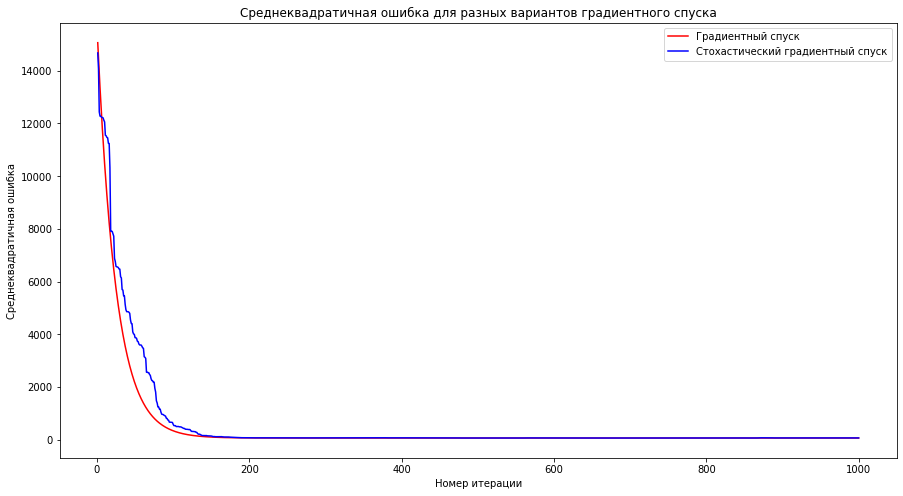

In [22]:
plt.figure(figsize = (15, 8))
plt.plot(np.arange(1, 1001), errors_gd, label = 'Градиентный спуск', color = 'r')
plt.plot(np.arange(1, 1001), errors_sgd, label = 'Стохастический градиентный спуск', color = 'b')
plt.legend()
plt.xlabel('Номер итерации')
plt.ylabel('Среднеквадратичная ошибка')
plt.title('Среднеквадратичная ошибка для разных вариантов градиентного спуска')
plt.show()

Из графика видно, что в случае градиентного спуска ошибка монотонно уменьшается, для стохастического варианта градиентного спуска среднеквадратичная ошибка также уменьшается, однако не так плавно. Это связано с тем, что в стохастическом градиентном спуске мы производим расчет градиента на одном случайно выбраном объекте, из-за этого на другом объекте ошибка может потенциально вырасти. Однако из графика видно, что в целом ошибка снижается и, начиная приблизительно со 130-ой итерации ошибки методов довольно близки.

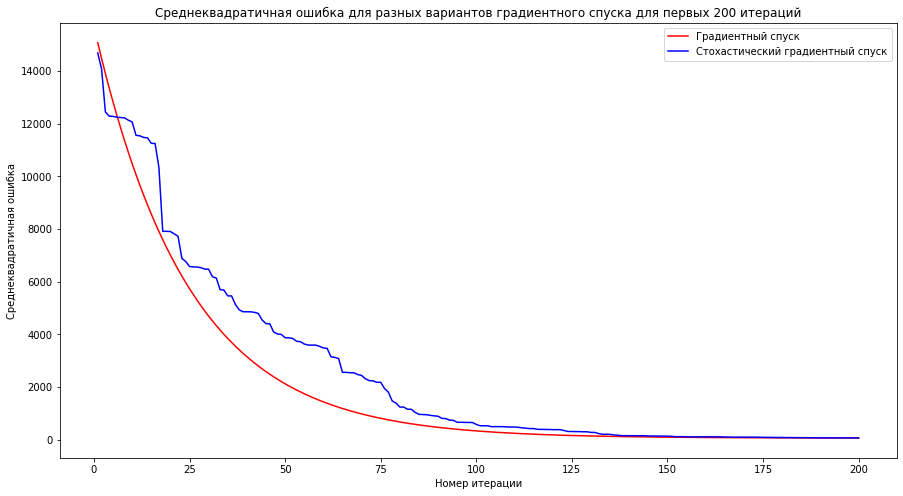

In [23]:
plt.figure(figsize = (15, 8))
plt.plot(np.arange(1, 201), errors_gd[:200], label = 'Градиентный спуск', color = 'r')
plt.plot(np.arange(1, 201), errors_sgd[:200], label = 'Стохастический градиентный спуск', color = 'b')
plt.legend()
plt.xlabel('Номер итерации')
plt.ylabel('Среднеквадратичная ошибка')
plt.title('Среднеквадратичная ошибка для разных вариантов градиентного спуска для первых 200 итераций')
plt.show()